In this notebook, we create data visualizations to highlight specicic points in the story.

In [3]:
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

#### Spatial distribution of dangerous dams and people affected in the country

In [6]:
def dangerous_dams_map():
    
    # Reads a map of the Brazilian states and regions
    states = gpd.read_feather("../../data/brazil/geobr/states.feather")
    regions = gpd.read_feather("../../data/brazil/geobr/regions.feather")
    
    # Reads all dams that have population living nearby
    dams = gpd.read_feather("../../data/brazil/snisb/dangerous-dams-population.feather")
    
    # Gets a centroid
    dams["geometry"] = dams.geometry.centroid
    
    # Creates a size column proportional to the people affected
    # Notice that bubble size is 100 lower than the affected population
    dams["bubble_size"] = dams.affected_population / 100
    
    # Let's translate and group the main usage categories
    def standardize_categories(row):

        categories = {
            "Water supply": ["Abastecimento humano", "Combate às secas", "Irrigação", "Dessedentação Animal"],
            "Mining or industry waste": ["Contenção de rejeitos de mineração", "Industrial", "Contenção de resíduos industriais"],
            "Other": ["Aquicultura", "Paisagismo", "Proteção do meio ambiente", "Recreação", "Regularização de vazão", "Defesa contra inundações"]
        }

        for k,v in categories.items():
            if row.uso_principal in v:
                category = k
                break


        return pd.Series({"category": category})
    
    dams["category"] = dams.apply(standardize_categories, axis=1)
    
    # Plots a regional map
    
    
    # Plots the Brazilian map on top
    ax=regions.plot(color="#b2bbc5", edgecolor="#d5dadf", figsize=(24,12))
    # RED – Mining or industry waste
    # GRAY – Other
    # Blue – Water supply
    cmap = ListedColormap(['#be232d', '#7f8891', '#01a5fe'])
    fig = dams.plot(markersize='bubble_size', alpha=1, column='category', legend=True, cmap=cmap, ax=ax)
    sns.despine()
    plt.axis('off')
        
    # Size legend
    sizes = [10, 100, 500] # 1000, 10000 and 50000 people
    handles = [ plt.scatter([],[], s=s) for s in sizes]
    labels = [str(size * 100) for size in sizes]
    
    size_legend = plt.legend(handles=handles, labels=labels, loc='upper left')

    #plt.savefig("../../output/img/bubble-map-population.svg") 

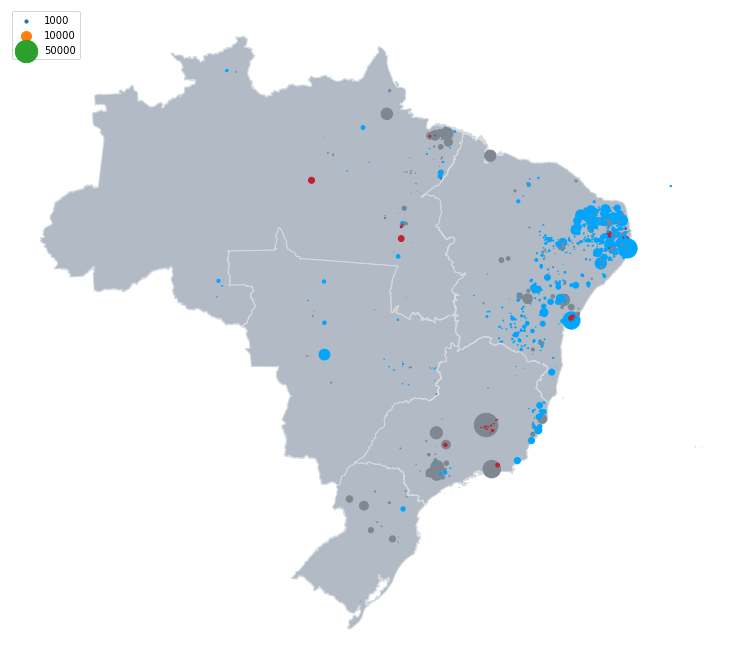

In [7]:
dangerous_dams_map()

#### Total dams by region X share of dams that are high risk, high damage potential

In [8]:
def dangerous_dams_by_region():
    
    # Reads regions
    regions = gpd.read_feather("../../data/brazil/geobr/regions.feather")
    
    # Reads data about all the dams
    dams = gpd.read_feather("../../data/brazil/snisb/all-dams-clean.feather")
    
    # Attributes a region to each dam
    dams = gpd.sjoin(dams, regions)
      
    # Group by region, count dams and plot
    ax = dams.groupby("region").codigo_snisb.count().plot(kind='barh', color='#eee')
    
    # Selects dangerous dams, group by region and plot
    dams[dams.high_risk_high_damage].groupby("region")\
        .codigo_snisb\
        .count()\
        .plot(kind='barh', color='#be232d', ax=ax, figsize=(20,12))
    
    sns.despine()

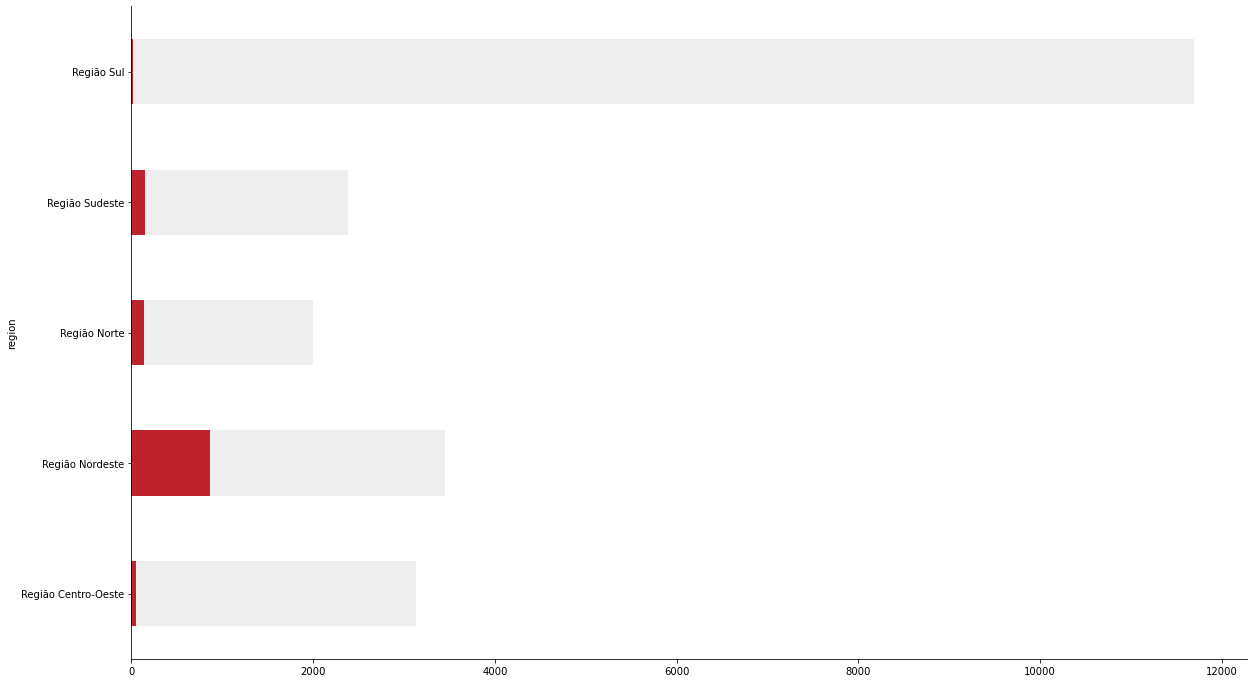

In [9]:
dangerous_dams_by_region()

#### How cities in different regions are affected

In [10]:
def city_stripplot():
    
    # Reads data on the cities and affected population
    cities = gpd.read_feather("../../data/brazil/near-dam-ratios/pop-near-dangerous-dams-by-city-with-response-capacity.feather")
    
    # Merges with the cities that have 0 people nearby
    basic_city_data = gpd.read_feather("../../data/brazil/cities/cities.feather")
    basic_city_data["code_muni"] = basic_city_data.code_muni.astype(int).astype(str).str.slice(0, -1)
    basic_city_data["code_state"] = basic_city_data.code_muni.astype(int).astype(str)
    basic_city_data["code_region"] = basic_city_data.code_muni.astype(int).astype(str)

    cities = cities[['code_muni', 'people_near_dangerous_dams', '10000_ratio', 'total_population', 'tem_orgao_defesa_civil']]\
        .merge(basic_city_data, on='code_muni', how='outer')
    
    # Fills nans with zeros – 0 people near dam
    cities = cities.fillna(0)
    
    fig, ax = plt.subplots(figsize=(12,8))
        
    sns.stripplot(ax=ax, y="name_region", x="10000_ratio", alpha=.5, size=5, data=cities, jitter=True, color='grey')

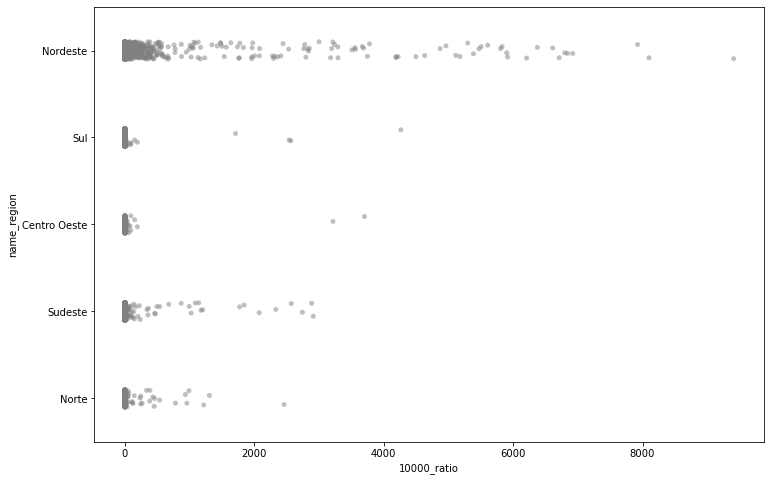

In [11]:
city_stripplot()

#### Lack of knowledge about state of dams

Where are the dams for which there is not enough information?

In [14]:
def map_dams_without_info():
    
    dams = gpd.read_feather("../../data/brazil/snisb/all-dams-clean.feather")
    regions = gpd.read_feather("../../data/brazil/geobr/regions.feather")
    
    dams = gpd.sjoin(dams, regions)
    
    cmap = ListedColormap(['#002d5a', '#f0c80f',  '#00a5ff'])


    # Plots the map
    ax=regions.plot(color="#eee", edgecolor="#fff", figsize=(24,12))
    dams.plot(markersize=2, alpha=.5, cmap=cmap, column='regulada_pela_pnsb', legend=True, ax=ax)
    sns.despine()

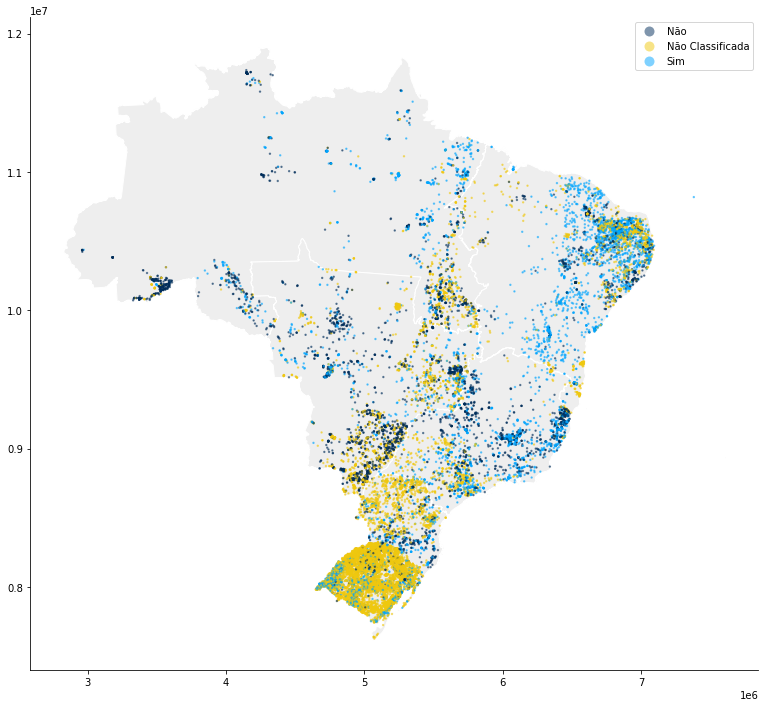

In [15]:
map_dams_without_info()

In [16]:
def share_of_dams_with_no_data():
    '''
    In how many dams there is not enough information 
    to determine if they should follow the PNSB?
    '''
    
    # Reads data about all the dams
    dams = gpd.read_feather("../../data/brazil/snisb/all-dams-clean.feather")
    
    cmap = ListedColormap(['#f0c80f', '#00a5ff', '#002d5a'])
    
    view = dams.regulada_pela_pnsb\
                .value_counts(normalize=True)\
                .to_frame()\
                .transpose()
    
    display(view)
    ax = view.plot(kind='barh', stacked=True, legend=False, cmap=cmap)
    
    ax.set_ylabel("")
    ax.set_yticklabels([])
    
    sns.despine()

,Não Classificada,Sim,Não
regulada_pela_pnsb,0.568178,0.242062,0.18976


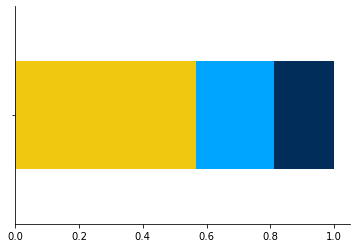

In [17]:
share_of_dams_with_no_data()

In [18]:
def pnsb_enforcement():
    '''
    How many dams that follow the PNSB
    are actually following the law
    standards, with all the safety and
    emergency plans recquired?
    '''
    
    # Reads dam files
    dams = gpd.read_feather("../../data/brazil/snisb/all-dams-clean.feather")
    
    # Keeps only dams that fall under the PNSB
    dams = dams[dams.regulada_pela_pnsb=="Sim"]

    #Which dams have both the safety plan and emergency plan requirements fullfiled?
    condition = (dams.possui_plano_de_seguranassa=="Sim") & ( 
         ((dams.dano_potencial_associado=="Alto") & (dams.possui_pae=="Sim")) | (dams.dano_potencial_associado!="Alto")
    )
    
    dams['pnsb_enforced'] = condition
    
    cmap = ListedColormap(['#cbd2d8', '#00a5ff'])

    enforcement = dams.pnsb_enforced.value_counts(normalize=True)\
                    .to_frame()\
                    .transpose()
        
    ax = enforcement.plot(kind='barh', stacked=True, legend=False, cmap=cmap)
    
    ax.set_ylabel("")
    ax.set_yticklabels([])

    sns.despine()

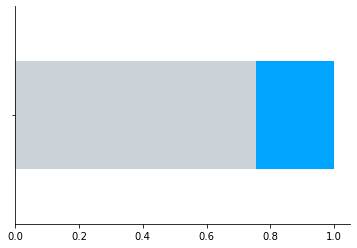

In [19]:
pnsb_enforcement()

#### What is the share of dams without proper data by region?

In [20]:
def lack_of_info_by_region():
    
    # Reads regions
    regions = gpd.read_feather("../../data/brazil/geobr/regions.feather")
    
    # Reads data about all the dams
    dams = gpd.read_feather("../../data/brazil/snisb/all-dams-clean.feather")
    
    # Attributes a region to each dam
    dams = gpd.sjoin(dams, regions)
      
    # Group by region, count dams and plot
    ax = dams.groupby("region").codigo_snisb.count().plot(kind='barh', color='#eee')
    
    # Selects dangerous dams, group by region and plot
    dams[dams.regulada_pela_pnsb=="Não Classificada"].groupby("region")\
        .codigo_snisb\
        .count()\
        .plot(kind='barh', color='#f0c80f', ax=ax, figsize=(20,12))
    
    sns.despine()

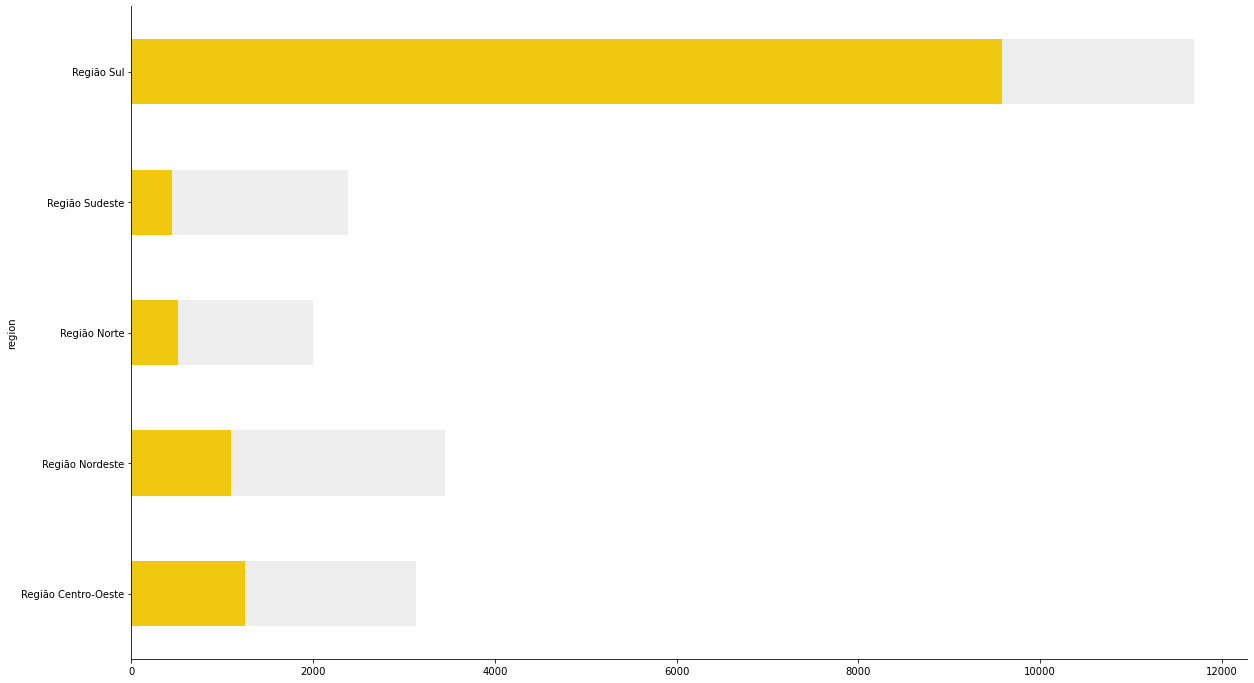

In [21]:
lack_of_info_by_region()

#### Plots large scale disasters

In [22]:
def plot_large_disasters():
    '''
    Plots a map with large scale dam disasters
    that happened in Brazil from 1986 to 2019,
    according to data collected by Mariano Andrade
    da Silva and Eliane Lima e Silva:
    https://www.scielo.br/j/sdeb/a/GxCcNJjsWLzNqmN9HbsFgqG/?lang=pt
    '''
    
    states = gpd.read_feather("../../data/brazil/geobr/states.feather")
    
    gdf = pd.read_csv("../../data/brazil/major-dam-failures.tsv", sep='\t')
    gdf['geometry'] = gdf.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
    gdf = gpd.GeoDataFrame(gdf)
    gdf.crs = "EPSG:4326"

    states = states.to_crs("EPSG:4326")
    states['geometry'] = states.geometry.simplify(.01)
        
    ax=states.plot(color="#b2bbc5", edgecolor="#d5dadf", figsize=(24,12))

    # Order: fish farming, hydropower, industrial, mining, water supply
    cmap = ListedColormap(['#002d5a', '#6ea500',  '#ee8c0a', '#be232d', '#00a5ff'])
    gdf.plot(column='kind', marker='x', s=10, legend=True, alpha=1, cmap=cmap, ax=ax)

    sns.despine()
    plt.axis('off')
    
    plt.savefig("../../output/img/map-large-failures.svg") 

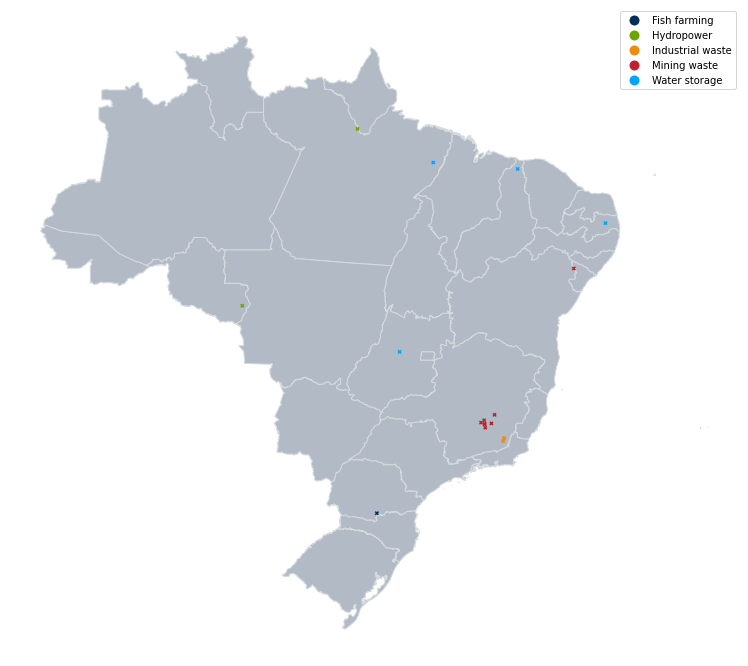

In [23]:
plot_large_disasters()